# Домашнее задание № 6

Сегодня мы будем  своими руками реализовывать градиентный бустинг на основе вычисления Lambda! 

В качестве базового алгоритма для бустинга будем использовать ```DecisionTreeRegressor``` из библиотеки ```sklearn```. Как было сказано в лекции, единственное существенное отличие — это целевые метки, на которые обучается каждое дерево: вместо типичных для бустинга ошибок (невязок) используются Lambda-значения. Функцию вычисления лямбд мы рассмотрели на практическом занятии. В решение необходимо осмысленно перенести реализацию в метод ```_compute_lambdas``` класса ```Solution```. 

## Параметры класса
```n_estimators``` — количество деревьев, которые будут строиться в рамках бустинга.

```lr``` — Learning Rate, коэффициент, на который умножаются предсказания каждого нового дерева в алгоритме (каждое дерево учится предсказывать значение lambda, но не факт, что добавление к текущим предсказаниям такого значения даст оптимум, поэтому весь “путь” оптимизации разбивается на маленькие шаги).

```subsample``` — доля объектов от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

```colsample_bytree``` — доля признаков от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

Совокупность двух вышеуказанных параметров позволяет реализовать метод случайных подпространств (смотрите описание по ссылке при необходимости). Понятно, что для применения деревьев (получения предсказания) нужно хранить индексы использованных признаков (но не объектов).

```max_depth``` и ```min_samples_leaf``` — параметры ```DecisionTreeRegressor```, отвечающие за глубину построения дерева и минимальное количество в терминальных (финальных) листьях дерева соответственно. 

## Методы класса
```_get_data```, ```_prepare_data```, ```_scale_features_in_query_groups```, ```_ndcg_k``` уже знакомы — можно перенести их реализацию  с тем лишь отличием, что для удобства срезов по индексам размерности ```ys_train``` и ```ys_test``` должны быть N∗1, где N-количество объектов (без этого грейдер будет отчитываться об ошибке).

```save_model``` и ```load_model``` — методы, отвечающие за сохранение и загрузку модели. Вам необходимо самостоятельно определить набор полей (их минимум 3), которые нужно сохранять после тренировки и загружать для предсказания. После ```load_model``` необходимо добиться, чтобы модель могла давать те же самые предсказания, что и до сохранения. Сохранение и загрузку реализуйте через модуль ```pickle```. Пример:

```bash
state = {…}
f = open(path, 'wb')
pickle.dump(state, f)
```

Предсказания формируются в методе ```predict```. На вход поступает тензор данных размерности N∗D, где N — количество объектов, D — количество признаков. На выходе ожидается применённый алгоритм бустинга, т.е. тензор предсказаний.

Расчёт метрики по набору данных должен производиться методом ```_calc_data_ndcg``` — в нём необходимо проитерироваться по группам запросов, посчитав в каждой ```NDCG```, после чего вернуть усреднённое значение метрики.

## Методы для тренировки
```_train_one_tree``` — метод для тренировки одного дерева. Принимает на вход ```cur_tree_idx``` — номер текущего дерева, который предлагается использовать в качестве random_seed для того, чтобы алгоритм был детерминирован. ```train_preds``` — суммарные предсказания всех предыдущих деревьев (для расчёта лямбд). В рамках метода необходимо рассчитать лямбды для каждой группы в тренировочном наборе данных, затем применить метод случайных подпространств, сделав срез по признакам (случайно выбранная группа, размер которой задан параметром ```colsample_bytree```) и по объектам (тоже случайно выбранная группа, размер зависит от параметра subsample). Затем произвести тренировку одного ```DecisionTreeRegressor```. Возвращаемые значения — это само дерево и индексы признаков, на которых обучалось дерево.

```fit``` — генеральный метод обучения K деревьев, каждое из которых тренируется с использованием метода ```_train_one_tree```. Изначальные предсказания до обучения предлагается приравнять к нулю и от этих значений отталкиваться при обучении первого дерева. Все обученные деревья необходимо сохранить в список, хранящийся в атрибуте trees класса ```Solution```. Для простоты и ускорения работы предлагается рассчитывать предсказания для всех тренировочных и валидационных данных после обучения каждого дерева (но досчитывать только изменения за последнее дерево, храня в памяти предсказания всех предыдущих). Следите за лучшим значением ```NDCG``` (хранить в переменной ```best_ndcg```) — после окончания тренировки нужно обрезать те последние N деревьев, которые лишь ухудшают метрику на валидации. Например, вы обучили 100 деревьев, и лучший результат был достигнут на 78-м. Тогда ```self.trees``` нужно обрезать до 78-го дерева, чтобы модель при предсказании работала лучше всего.

## Критерии оценки
- Корректная предобработка данных.
- Модель адекватно отработала на 1 дереве, ```NDCG``` выше порога случайных предсказаний.
- Модель на 100 деревьев на подложенных данных обучается, ```NDCG≥0.425```.
- Обученная и сохраненная модель после загрузки корректно дала предсказания в методе ```predict```.

In [1]:
from catboost.datasets import msrank_10k
import torch 
from hw6_solved import Solution

D:\AnacondaGO\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Запуск и сохранение модели

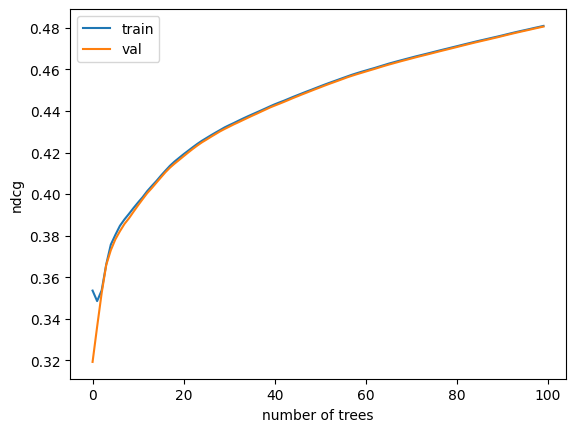

tree: 99
ndcg on train: 0.4808744045766503
ndcg on validation: 0.4805567794342748


In [2]:
sol = Solution()
sol.fit()
#sol.load_model("model.pckl")

In [3]:
train_data, test_data = msrank_10k()

In [4]:
X_test = test_data.drop([0], axis=1) # идентификатор группы объекта оставляем 
y_test = torch.FloatTensor(test_data[0]).reshape(-1,1)
q_ids_test = test_data[1].values.astype(int)

In [5]:
result = sol.predict(X_test)

In [6]:
result, y_test

(tensor([[ 0.0826],
         [-0.4676],
         [-0.3094],
         ...,
         [-0.1104],
         [-0.9444],
         [ 0.7315]], dtype=torch.float64),
 tensor([[2.],
         [1.],
         [3.],
         ...,
         [1.],
         [1.],
         [1.]]))

In [7]:
sol._calc_data_ndcg(q_ids_test, y_test, result)

0.4802533904078725

In [8]:
sol.save_model("model.pckl")

In [9]:
sol1 = Solution()

In [10]:
sol1.load_model("model.pckl")

In [11]:
sol1.predict(X_test) == result

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]])

In [15]:
np.unique(y_test) 

array([0., 1., 2., 3., 4.], dtype=float32)

In [14]:
import numpy as np 

In [17]:
np.unique(sol.ys_train) 

array([0., 1., 2., 3., 4.], dtype=float32)

In [18]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,13,2,0,2,1,2,1.0,0.0,1.00,...,35,1,0,266,25070,28,7,0,0,0.0
1,1.0,13,2,0,0,0,2,1.0,0.0,0.00,...,17,93,0,153,12860,65,158,0,0,0.0
2,3.0,13,2,0,1,0,2,1.0,0.0,0.50,...,19,0,0,153,1131,112,141,0,0,0.0
3,1.0,13,2,0,2,1,2,1.0,0.0,1.00,...,50,81775,0,560,61224,1,14,0,0,0.0
4,0.0,13,1,0,0,0,1,0.5,0.0,0.00,...,24,0,0,57953,15600,15,12,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1303,2,0,1,0,2,1.0,0.0,0.50,...,28,15,0,57657,31060,3,11,0,0,0.0
9996,1.0,1303,2,2,2,0,2,1.0,1.0,1.00,...,47,14629,12,34443,32707,1,1,0,3,35.0
9997,1.0,1303,2,0,1,1,2,1.0,0.0,0.50,...,44,149,0,52732,40897,2,5,0,0,0.0
9998,1.0,1318,4,0,3,3,4,1.0,0.0,0.75,...,66,0,4,192,65535,3,3,0,0,0.0
